<a href="https://colab.research.google.com/github/molnason/01ZLMA/blob/main/Face_drawing_guide_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Drawing Guide

**Authors:** S. Molnárová, J.Kreanová



## Abstract:

Face drawing guide is an AI tool inspired by Loomis method meant to help beginners in traditional art, so called art babies, to gain some insight in drawing portraits.

The main goal of this project is to divide a face in an uploaded photography into simple shapes. We chose to focus on drawing a circle to represent cranium and an ellipse as a chin. This division is supossed to help sketching the main structure of the face and strenghten the mental library of the artist to draw faces without reference in future if they wish to.

We decided to use a self-constructed dense neural network (NN). The goal was to train a NN which would detect the radius and center coordinates of a circle and ellipse which would best approximate the given face. MediaPipe was later utilized in the training process which resulted in a better performance of the network.

As a result, our project introduced a fully functioning, MedaiPipe dependent neural network approach to face drawing.

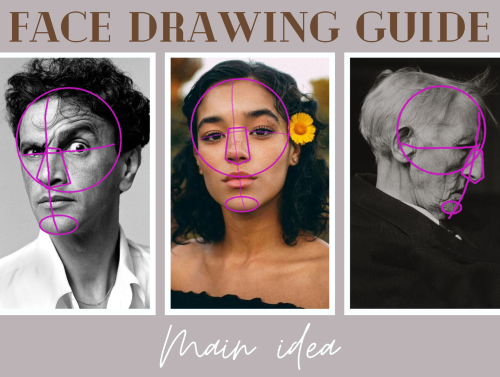

## Methodology



**DATASET:** As we opted for a rather specific task, before we could move on to training any neural network, we had to prepare an annotated dataset designed for our intended usage. For this purpose, an annotation function was written which enabled us to construct circles and ellipses fitting faces in an interactive way. The images used came from a chosen dataset found on Kaggle.

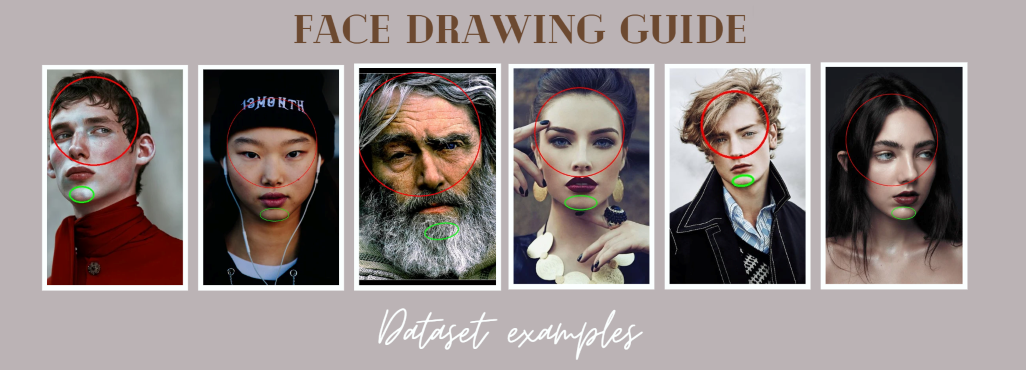





**APPROACH:** We considered multiple approaches how to cunstruct the network. They will be briefly described in the following points:

1. **Dlib:** Our first initiative was to use Dlib library to detect keypoints defining a face landmark. These were supposed to serve as supporting points for circle radius estimation. However, this approach did not prove to be successful as dlib face detection failed in approximately 10 % of the annotated images, which would rather significantly lower the dimension of our training set.
        
2. **MTCNN:** We also tried utilizing transfer learning by fine-tuning a final layer of the face landmark detection in MTCNN. Instead of detecting eyes, mouth and nose, we wanted to adjust the layer to detect our points of interest. This approach was left unfinished because of its unnecessary complexity and time consumption.
        
3. **MediaPipe:** MediaPipe proved a lot more robust to face rotation and profiling than the previously mentioned Dlib. Furthermore enriching the data with additional points resulted in improved performance of the constructed model. The model was formed by combining four linear layers followed by a ReLU non-linearity. This fixed the high time durability of MTCNN.  Improved robustness and lower complexity were the advantages which made it a preferred approach.

4. **Other considered approaches:** GANs (approach not chosen because of the authors' unfamiliarity with the concept in early stages of the project development)



## Code

In [ ]:
%%capture
!pip install lightning
!pip3 install wandb
!pip install mediapipe

In [ ]:
# Required Libraries
import torch
import cv2 as cv
import os
import glob
import matplotlib.pyplot as plt
import gdown
from google.colab.patches import cv2_imshow
import numpy as np
import wandb
import pandas as pd

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.nn import Linear, MSELoss, ReLU, Mish, Dropout
from torch.optim import SGD, AdamW
import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger, WandbLogger

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

*Loading the dataset of faces*

Dataset contains 3251 manually annotated images with their corresponding labels saved as text files. This is the final dataset which remained after filtering out all images not recognized by MediaPipe. The former dataset contained 3469 annotated images. The use of MediaPipe therefore lowered the data loss by approximately 4 %. The `load_ds` function also flips all images leaving us with 6502 images which can be used for training and validation.

In [ ]:
%%capture
ulr='https://drive.google.com/uc?id=1XbW4bKJfNFfCLJ2-TsIWpPT4pbzht4PK'
output='faces.zip'
gdown.download(ulr,output,quiet=False)
!unzip "/content/faces.zip" -d "/content"

*Loading presaved landmarks*

In [ ]:
%%capture
ulr='https://drive.google.com/uc?id=1H0DvLLQKkYzzlEubemoqcjiCfPbskHLE'
output='fc_landm_pipe.zip'
gdown.download(ulr,output,quiet=False)
!unzip "/content/fc_landm_pipe.zip" -d "/content/faces"

### Dense neural network

*Data preprocessing*

First it is necessary to convert the images with their labels from the annotated data into a format suitable for pytorch's data loader.

In [ ]:
def load_ds():
        x=[] #landmarks
        y=[] #circlescellipses

        #mediapipe
        fc_lm="fc_landm_pipe"
        lm_end="_landm_pipe.txt"
        nm_l=478

        filetypes=["jpg","jpeg","png"]

        files=[]
        for ft in filetypes:
          files.extend(glob.glob("faces/*."+ft))
        files.sort()


        for f in files:
          circles=[]
          landmarks=[]
          elipses=[]
          head, tail = os.path.split(f)
          file_lm=os.path.join(head , fc_lm , tail +lm_end)
          if os.path.isfile(f+".txt") and os.path.isfile(file_lm):
            fa = open(f+".txt", "r")
            lines=fa.readlines()
            fa.close()

            for l in lines:
              p=l.split(";")

              if int(p[0])==0:
                circles.append([int(p[1]),int(p[2]),int(p[3])])

              if int(p[0])==1:
                el=[int(p[1]),int(p[2]),int(p[3]),int(p[4]),float(p[5])]
                if el[2]<el[3]: #chceme a velka poloosa, b mala poloosa
                  tmp=el[2]
                  el[2]=el[3]
                  el[3]=tmp
                  el[4]+=90

                while el[4]<-90:
                  el[4]+=180

                while el[4]>=90:
                  el[4]-=180

                elipses.append(el)

            fd = open(file_lm, "r")
            lines=fd.readlines()
            fd.close()

            for l in lines:
              p=l.split(";")
              if len(p)>1:
                landmarks.append([int(p[0]),int(p[1])])

          if(len(circles)==1 and len(elipses)==1 and len(landmarks)==nm_l):
            lm=np.array(landmarks)

            cog=np.mean(lm, axis=(0))
            lm=lm-cog
            coef=np.max(np.abs(lm))
            lm=lm/coef
            lm_flip=np.copy(lm)
            lm_flip[:,0]=-1*lm_flip[:,0]
            x.append(lm.flatten().tolist())
            x.append(lm_flip.flatten().tolist())
            c=circles[0]
            e=elipses[0]
            y.append([(c[0]-cog[0])/coef,
                      (c[1]-cog[1])/coef,
                      c[2]/coef,
                      (e[0]-cog[0])/coef,
                      (e[1]-cog[1])/coef,
                      e[2]/coef,
                      e[3]/coef,
                      e[4]/180.0
                      ])
            y.append([(c[0]-cog[0])/coef*(-1),
                      (c[1]-cog[1])/coef,
                      c[2]/coef,
                      (e[0]-cog[0])/coef*(-1),
                      (e[1]-cog[1])/coef,
                      e[2]/coef,
                      e[3]/coef,
                      -e[4]/180.0
                      ])
        return x,y

*Data module construciton*

In [ ]:
class FDGDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=30):
        super().__init__()
        self.batch_size = batch_size
        x,y=load_ds()
        self.dataset = TensorDataset(torch.tensor(x,dtype=torch.float), torch.tensor(y,dtype=torch.float))


    def setup(self, stage=None):
        self.train,self.val,self.test=torch.utils.data.random_split(self.dataset,(0.8,0.1,0.1))



    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size)


    def val_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size)

    def test_dataloader(self):
         return DataLoader(self.test, batch_size=self.batch_size)

*Model object*

Model was constructed by layering 4 linear layers followed by ReLU activation function. The simplicity of the model makes it fast to train which is one of its main advantages.

In [ ]:
class FDGModel(pl.LightningModule):
    def __init__(self):
        super(FDGModel,self).__init__()
        self.linear1 = Linear(2*478, 478)
        self.linear2 = Linear(478, 478)
        self.linear4 = Linear(478, 136)
        self.linear6 = Linear(136, 8)
        self.loss_fn = MSELoss()
        self.relu=ReLU()
        self.relu2=Mish()
        self.drop=Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.drop(x)
        x = self.relu(self.linear2(x))
        x = self.drop(x)
        x = self.relu(self.linear4(x))
        x = self.drop(x)
        x = self.linear6(x)


        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = self.loss_fn(y_hat, y)
        self.log('val_loss', val_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        test_loss = self.loss_fn(y_hat, y)
        self.log('test_loss', test_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return test_loss

    def predict_step(self, batch, batch_idx):
        x, _ = batch
        y_hat = self(x)
        return y_hat

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.001)


*Model training*

Model is trained for 200 epochs using colab available GPU.

In [ ]:
logger = CSVLogger("logs", name="FDG_log")
#wandb.login()
#logger = WandbLogger(project="FDG_dlib")

# Initialize the model and data module
model = FDGModel()
data_module = FDGDataModule()

# Get the number of available GPUs, else use CPU(koľko mame grafickych kariet)
ngpus = torch.cuda.device_count() if torch.cuda.is_available() else 1

# Train and Validate the model
trainer = pl.Trainer(logger=logger, devices=ngpus, accelerator="gpu" if ngpus > 0 else None, max_epochs=200)
trainer.fit(model, data_module)

trainer.test(model, datamodule=data_module)

#wandb.finish()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type    | Params
------------------------------------
0 | linear1 | Linear  | 457 K 
1 | linear2 | Linear  | 228 K 
2 | linear4 | Linear  | 65.1 K
3 | linear6 | Linear  | 1.1 K 
4 | loss_fn | MSELoss | 0     
5 | relu    | ReLU    | 0     
6 | relu2   | Mish    | 0     
7 | drop    | Dropout | 0     
------------------------------------
752 K    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │   0.0028162896633148193   │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.0028162896633148193}]

In [ ]:
checkpoint_path = "modelFDG_checkpoint.ckpt"
trainer.save_checkpoint(checkpoint_path)

*Model evaluation*

MSE was chosen as the task's loss function because of its connection to L2 norm. The deviation of the detected values and label values is penalized quadratically. That means that higher deviations have quadratically higher loss than smaller deviations and are therefore penalized more severely. This approach is suitable for coordinates and radius prediction whose deviations from ground truth are well described by L2 norm.

In [ ]:
log_file = '/content/logs/FDG_log/version_0/metrics.csv'
df = pd.read_csv(log_file)
df_grouped = df.groupby('epoch').first().reset_index()
df_grouped

,epoch,step,train_loss_step,val_loss_step,val_loss_epoch,train_loss_epoch,test_loss_step,test_loss_epoch
0,0.0,49,0.012549,NaN,0.004221,0.016670,NaN,NaN
1,1.0,199,0.008041,NaN,0.004058,0.008179,NaN,NaN
2,2.0,349,0.007751,NaN,0.004856,0.007043,NaN,NaN
3,3.0,549,0.005913,NaN,0.004141,0.006370,NaN,NaN
4,4.0,699,0.006600,NaN,0.004196,0.005587,NaN,NaN
...,...,...,...,...,...,...,...,...
196,196.0,33749,0.002013,NaN,0.002803,0.002894,NaN,NaN
197,197.0,33899,0.002599,NaN,0.002779,0.003009,NaN,NaN
198,198.0,34099,0.002972,NaN,0.002994,0.002983,NaN,NaN
199,199.0,34249,0.002216,NaN,0.003018,0.002991,NaN,NaN


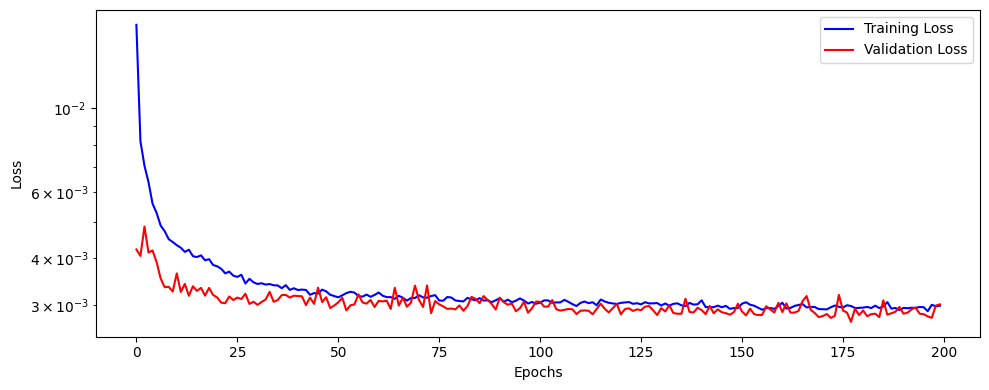

In [ ]:
def plot_csv_losses(df_cleaned):
    fig = plt.figure(figsize=(10, 4))
    plt.plot(df_cleaned['epoch'], df_cleaned['train_loss_epoch'], label='Training Loss', c='b')
    plt.plot(df_cleaned['epoch'], df_cleaned['val_loss_epoch'], label='Validation Loss', c='r')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_csv_losses(df_grouped)

It is unusual to see a validation loss smaller than its corresponding training loss. What we assume happened is that some images from the training dataset leaked into the validation process. We realized quite late into the annotating that many of the images in the dataset were duplicates. Two people were included in the annotation process with no awareness of the other's dataset contents which made duplicates all the more likely.

### Demonstration

The results are shown in the following form:

*  circle ... (center_x, center_y, diameter)
*  ellipse ... (center_x, center_y, axis a, axis b, rotation angle from the horizontal axis)
   * a, b are axes, not semi-axes!

The user can choose the metrics he or she wants to use for drawing. Original pixel scale or absolute image width can be used for scaling as well as an ellipse.



In [ ]:
%%capture
ulr='https://drive.google.com/uc?id=1RmJoofMPHRPq3sGLUt-RsFkT5ULR-X3F'
output='faces_not_seen.zip'
gdown.download(ulr,output,quiet=False)
!unzip "/content/faces_not_seen.zip" -d "/content"

Now let's see some Barbies and just Kens...

In [ ]:
def predict_img(f,model,detector,prep=0):
    img =  mp.Image.create_from_file(f)

    detection_result = detector.detect(img)
    lmks = detection_result.face_landmarks
    xyz_coordinates = [[point.x, point.y, point.z] for landmark_list in lmks for point in landmark_list]
    landmarks=[]

    for u,p in enumerate(xyz_coordinates):
      cord=np.multiply(np.array(p),np.array([img.width,img.height,img.width])).astype(int)
      landmarks.append([cord[0],cord[1]])
      xyz_coordinates[u]=cord

    if len(landmarks)!=0:

      lm=np.array(landmarks)
      cog=np.mean(lm, axis=(0))
      lm=lm-cog
      coef=np.max(np.abs(lm))
      lm=lm/coef
      imp=torch.tensor(lm.flatten().tolist())
      model.eval()  # Set the model to evaluation mode

      with torch.no_grad():  # Don't track gradients
          imp = imp.to(device)  # Move to device
          predicted = model(imp)
      predicted = predicted.cpu().numpy()
      predicted[0:7]=predicted[0:7]*coef
      predicted[0]=predicted[0]+cog[0]
      predicted[1]=predicted[1]+cog[1]

      predicted[3]=predicted[3]+cog[0]
      predicted[4]=predicted[4]+cog[1]
      predicted[7]=predicted[7]*180

      #img=cv.imread(f)
      #cv.circle(img,(int(predicted[0]),int(predicted[1])),int(predicted[2]),(0,0,255),4)
      #cv.ellipse(img,(int(predicted[3]),int(predicted[4])),(int(predicted[5]),int(predicted[6])),float(predicted[7]),0,360,(255,0,255),4)

      control_points=np.array(landmarks)[[152,0,5,10],:]
      horiz_pt=np.array(landmarks)[[162,33,6,263,389],:]

      #for i in range(len(control_points) - 1):
      #  cv.line(img, tuple(control_points[i]), tuple(control_points[i + 1]), (212, 255, 127), 2)
      #for i in range(len(horiz_pt) - 1):
      #  cv.line(img, tuple(horiz_pt[i]), tuple(horiz_pt[i + 1]), (212, 255, 127), 2)

      #cv2_imshow(cv.resize(img,[300,int(img.shape[0]*300/img.shape[1])]))
      if prep==1:
        #prepocet na širku obr
        w=img.shape[1]
        predicted[0:7]=predicted[0:7]*100/w


      if prep==2:
        #prepočet na 1 elipsu
        bb=2*predicted[6]
        predicted[0:7]=predicted[0:7]/bb

      circ_f=[predicted[0:3]]
      circ_f[0][2]*=2 #c(x,y,diameter)
      ell_f=[predicted[3:8]]
      ell_f[0][2:4]*=2 #e(x,y)

    else:
      circ_f=[]
      ell_f=[]

    return circ_f,ell_f


In [ ]:
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

In [ ]:
device = next(model.parameters()).device
filetypes=["jpg","jpeg","png"]

files=[]
for ft in filetypes:
  files.extend(glob.glob("faces_not_seen/*."+ft))
files.sort()


for f in files:
  cf,ef=predict_img(f,model,detector)
  print("Circle found: ",cf)
  print("Ellipse found: ",ef)

error: ignored

Try out for yourselves... 😃

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)



In [ ]:
ulr='https://drive.google.com/uc?id=1OA4h3nAunH_LBWN54-TnYnvsgOsEYQJr'
output='model_FDG_checkpoint.ckpt'
gdown.download(ulr,output,quiet=False)

#!wget -O model_FDG_checkpoint.ckpt -q https://github.com/Strojove-uceni/23206-final-face-drawing-guide/blob/d49b8ba6534463eba3234038dd7150d672237f79/aditional%20codes/model_FDG_checkpoint.ckpt


chp_pt="/content/model_FDG_checkpoint.ckpt"
# Load the saved state from the checkpoint file
loaded_model = FDGModel.load_from_checkpoint(chp_pt)
device = next(loaded_model.parameters()).device

Downloading...
From: https://drive.google.com/uc?id=1OA4h3nAunH_LBWN54-TnYnvsgOsEYQJr
To: /content/model_FDG_checkpoint.ckpt
100%|██████████| 9.04M/9.04M [00:00<00:00, 66.4MB/s]


In [ ]:
filetypes = ["jpg", "jpeg", "png"]
format=2 #0<->px...1<->%....2<->elipsa
for up in list(uploaded.keys()):
  _, file_extension = os.path.splitext(up)
  file_extension = file_extension[1:].lower()
  if file_extension in filetypes:
    cf,ef=predict_img(up,loaded_model,detector,2)

    if format==1:
      print("Proportions given by ercentage of width:")
    elif format==2:
      print("Proportions given by height of elipse (recommended):")
    else:
      print("Proportions given in pixels:")

    print("Circle found: ",cf)
    print("Ellipse found: ",ef)


NameError: ignored

## Conclusion

We trained a dense neural network utilizing MediaPipe landmarking. The network performed especially well on faces directly facing the camera. Prior to training it was also necessary to write a script for image annotation `FDG_anot.py`. With its help we managed to annotate well over 3000 images.

A significant limitation stems from MediaPipe performace on the data. Although we obtained better results compared to Dlib detection, some of the images still had to be removed from the training dataset as some faces were not detected properly. Grayscale images were found to be especially problematic together with partially covered and heavily rotated faces.

As previously mentioned when talking about the loss function, image duplicates presented a big problem for the task. These artificially lowered our validation loss while possibly "throwing the network off" by inconsistent annotation.

Right now, the model is only capable of drawing one circle and one ellipse in every image. A possible future improvement would therefore be to generilize the model to handle more than one face in one picture.

It would also be worth trying to train both the circles and ellipses by separate networks which might result into better accuracy.

Possible upgrades for the future are adding mandible shape, nose, lips and eventually eyes and expressions. Transfering the project into a mobile applicatoin in distant future is also possible.





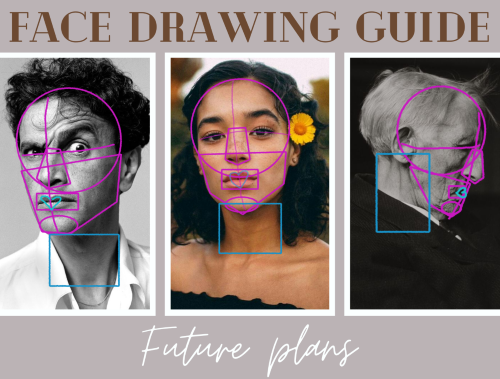

## References


1.   [Lectures](https://su2.utia.cas.cz/lectures.html) and [labs](https://su2.utia.cas.cz/labs.html)
2.   [Landmark detection](https://github.com/tensorflow/tfjs-models/blob/838611c02f51159afdd77469ce67f0e26b7bbb23/face-landmarks-detection/src/mediapipe-facemesh/keypoints.ts)
3.   [MediaPipe](https://developers.google.com/mediapipe/solutions/vision/face_landmarker)
4.   [MediaPipe demo](https://github.com/googlesamples/mediapipe/blob/main/examples/face_landmarker/python/[MediaPipe_Python_Tasks]_Face_Landmarker.ipynb)


### *Accuracy

In [ ]:
def get_annotations(root_dir):
        circle_annotations = []
        ellipse_annotations = []

        image_files = [f for f in os.listdir(root_dir) if f.endswith(".jpg")]

        for image_file in image_files:
          image_path = os.path.join(root_dir, image_file)
          annotation_path = os.path.join(root_dir, f"{os.path.splitext(image_file)[0]}.jpg.txt")

          if os.path.exists(annotation_path):
              with open(annotation_path, 'r') as file:
                  lines = file.readlines()

                  # Ensure both lines contain non-empty strings
                  if lines and lines[0].strip():
                      # Extracting circle and ellipse parameters from the annotation file
                      circle_params = list(map(float, lines[0].strip().split(';')[:-1]))

                      # Check if there's a second line (ellipse) and process it
                      if len(lines) > 1 and lines[1].strip():
                          ellipse_params = list(map(float, lines[1].strip().split(';')[:-1]))
                      else:
                          ellipse_params = []

                      circle_annotations.append(np.array(circle_params))
                      ellipse_annotations.append(np.array(ellipse_params))

        return circle_annotations, ellipse_annotations

def get_predicted(root_dir):
        circle_predictions = []
        ellipse_predictions = []

        filetypes=["jpg"]
        path = root_dir

        files=[]
        for ft in filetypes:
          files.extend(glob.glob(root_dir+"/*."+ft))
        files.sort()

        for f in files:
          circle, ellipse = predict_img(f,model,detector)

          circle_predictions.append(np.array(circle)[0])
          ellipse_predictions.append(np.array(ellipse)[0])

        return circle_predictions, ellipse_predictions


def get_intersection_circle(circle_annotated, circle_predicted):
        x1, y1, r1 = circle_annotated[1:]
        x2, y2, r2 = circle_predicted[:3]
        resolution = 100

        r1 = r1/2
        r2 = r2/2

        # Create a grid
        x = np.linspace(min(x1 - r1, x2 - r2), max(x1 + r1, x2 + r2), resolution)
        y = np.linspace(min(y1 - r1, y2 - r2), max(y1 + r1, y2 + r2), resolution)
        xx, yy = np.meshgrid(x, y)

        # Check intersection condition for each point
        intersection_mask = ((xx - x1)**2 + (yy - y1)**2 <= r1**2) & ((xx - x2)**2 + (yy - y2)**2 <= r2**2)

        # Count intersection area
        intersection_count = np.sum(intersection_mask)

        return intersection_count

def get_intersection_ellipse(ellipse_annotated, ellipse_predicted):
        x1, y1, a1, b1 = ellipse_annotated[1:]
        x2, y2, a2, b2 = ellipse_predicted[:4]
        resolution = 100

        a1 = a1/2
        a2 = a2/2
        b1 = a2/2
        b2 = b2/2

        # Create a grid
        x = np.linspace(min(x1 - a1, x2 - a2), max(x1 + a1, x2 + a2), resolution)
        y = np.linspace(min(y1 - b1, y2 - b2), max(y1 + b1, y2 + b2), resolution)
        xx, yy = np.meshgrid(x, y)

        # Check intersection condition for each point
        intersection_mask = (
            ((xx - x1) ** 2) / (a1 ** 2) + ((yy - y1) ** 2) / (b1 ** 2) <= 1
        ) & (
            ((xx - x2) ** 2) / (a2 ** 2) + ((yy - y2) ** 2) / (b2 ** 2) <= 1
        )

        # Count intersection area
        intersection_count = np.sum(intersection_mask)

        return intersection_count

def get_union_circle(circle_annotated, circle_predicted, resolution=100):
        x1, y1, r1 = circle_annotated[1:]
        x2, y2, r2 = circle_predicted[:3]

        r1 = r1/2
        r2 = r2/2

        # Create a grid
        x = np.linspace(min(x1 - r1, x2 - r2), max(x1 + r1, x2 + r2), resolution)
        y = np.linspace(min(y1 - r1, y2 - r2), max(y1 + r1, y2 + r2), resolution)
        xx, yy = np.meshgrid(x, y)

        # Check if each point is inside both circles
        circle_annotated_mask = ((xx - x1) ** 2 + (yy - y1) ** 2) <= r1 ** 2
        circle_predicted_mask = ((xx - x2) ** 2 + (yy - y2) ** 2) <= r2 ** 2

        # Count intersection area
        intersection_count = np.sum(circle_annotated_mask | circle_predicted_mask)

        return intersection_count


def get_union_ellipse(ellipse_annotated, ellipse_predicted, resolution=100):
        x1, y1, a1, b1 = ellipse_annotated[1:]
        x2, y2, a2, b2 = ellipse_predicted[:4]

        a1 = a1/2
        a2 = a2/2
        b1 = a2/2
        b2 = b2/2

        # Create a grid
        x = np.linspace(min(x1 - a1, x2 - a2), max(x1 + a1, x2 + a2), resolution)
        y = np.linspace(min(y1 - b1, y2 - b2), max(y1 + b1, y2 + b2), resolution)
        xx, yy = np.meshgrid(x, y)

        # Check if each point is inside either ellipse
        ellipse1_mask = ((xx - x1) ** 2) / (a1 ** 2) + ((yy - y1) ** 2) / (b1 ** 2) <= 1
        ellipse2_mask = ((xx - x2) ** 2) / (a2 ** 2) + ((yy - y2) ** 2) / (b2 ** 2) <= 1

        # Count union area
        union_count = np.sum(ellipse1_mask | ellipse2_mask)

        return union_count

def get_accuracy_circle(root_dir):
        accuracies = []

        anot_c_list, _ = get_annotations(root_dir)
        pred_c_list, _ = get_predicted(root_dir)

        for anot, pred in zip(anot_c_list, pred_c_list):
          intersection = get_intersection_circle(anot, pred)
          union = get_union_circle(anot, pred)
          accuracies.append(intersection/union)

        print(np.sum(accuracies)/len(accuracies))

def get_accuracy_ellipse(root_dir):
        accuracies = []

        _, anot_e_list = get_annotations(root_dir)
        _, pred_e_list = get_predicted(root_dir)

        for anot, pred in zip(anot_e_list, pred_e_list):
          intersection = get_intersection_ellipse(anot, pred)
          union = get_union_ellipse(anot, pred)
          accuracies.append(intersection/union)

        print(np.sum(accuracies)/len(accuracies))


In [ ]:
get_accuracy_circle("faces")

0.10079341994698862


In [ ]:
anot_c, anot_e = get_annotations("faces")
pred_c, pred_e = get_predicted("faces")



In [ ]:
for anot, pred in zip(anot_c, pred_c):
  print((get_intersection_circle(anot, pred), get_union_circle(anot, pred)))

(1746, 6913)
(887, 7668)
(1400, 7345)
(472, 7109)
(0, 7641)
(334, 7498)
(1471, 7583)
(169, 6860)
(0, 4887)
(0, 3801)
(1623, 7150)
(0, 7329)
(1834, 7668)
(0, 6499)
(991, 7668)
(106, 6757)
(2340, 7675)
(0, 5592)
(0, 5749)
(0, 6168)
(1422, 7668)
(275, 7067)
(1810, 7714)
(1573, 7668)
(0, 3437)
(1687, 7668)
(0, 3609)
(0, 4691)
(0, 6004)
(0, 2802)
(1619, 7668)
(8, 6476)
(0, 4858)
(1248, 7268)
(2193, 7417)
(1233, 7668)
(1952, 7668)
(878, 7668)
(0, 3859)
(0, 3778)
(0, 6407)
(0, 4150)
(461, 7574)
(0, 5453)
(395, 7866)
(1109, 7668)
(1357, 7668)
(72, 7777)
(1824, 7668)
(442, 7668)
(878, 7258)
(0, 3502)
(527, 7668)
(0, 5359)
(1304, 7668)
(370, 7668)
(1064, 6624)
(0, 2873)
(1940, 7668)
(0, 6381)
(1352, 7671)
(0, 4158)
(25, 7366)
(0, 5076)
(0, 1831)
(0, 3777)
(760, 7281)
(0, 7722)
(0, 4255)
(2318, 7668)
(92, 7021)
(0, 4278)
(0, 2199)
(589, 7668)
(365, 6167)
(1326, 7668)
(0, 6607)
(0, 1130)
(2352, 7448)
(10, 6732)
(0, 5251)
(1550, 7272)
(4, 5696)
(0, 2669)
(2426, 7222)
(355, 6270)
(0, 6099)
(0, 5412)